In [1]:
sc.install_pypi_package("pandas", "https://pypi.org/simple")
sc.install_pypi_package("matplotlib", "https://pypi.org/simple")
sc.install_pypi_package("seaborn", "https://pypi.org/simple")
sc.install_pypi_package("scipy", "https://pypi.org/simple")
sc.install_pypi_package("ipython", "https://pypi.org/simple")

sc.install_pypi_package("shap", "https://pypi.org/simple")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pyspark.sql.types import DoubleType
import math
from pyspark.sql.functions import *
from pyspark.ml.feature import StandardScaler,MinMaxScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier,LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from shap import TreeExplainer
import shap
shap.initjs()


pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

## Read in sparkify dataset for EDA
#event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
event_data = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
user_log_small = spark.read.json(event_data)
user_log_small.printSchema()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
4,application_1709608240958_0005,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1709608240958_0005/container_1709608240958_0005_01_000001/tmp/spark-5a7a4b1f-1835-4dcb-b2ea-0b74c7333641
    Can't uninstall 'python-dateutil'. No files were found to uninstall.




  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.24
    Not uninstalling prompt-toolkit at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1709608240958_0005/container_1709608240958_0005_01_000001/tmp/spark-5a7a4b1f-1835-4dcb-b2ea-0b74c7333641
    Can't uninstall 'prompt-toolkit'. No files were found to uninstall.


<IPython.core.display.HTML object>
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: str

In [2]:
# Generate churn feature
user_log_small.createOrReplaceTempView('user_log_small_table')
user_log_small = user_log_small.na.drop(subset=['firstName'])

user_churn = spark.sql('''
        SELECT userId,
               MAX(IF(page = "Cancellation Confirmation",1,0)) as churn
        FROM user_log_small_table
        GROUP BY userId
''')

# Generate features related to user gender:
# Feature 1: gender_cate - Mapping gender values: 'M' to 1, 'F' to 0.

user_gender = spark.sql('''
    SELECT userId,
           SUBSTRING_INDEX(ANY_VALUE(location),', ',-1) as location,
           ANY_VALUE(gender) as gender,
           IF(ANY_VALUE(gender)='M',1,0) as gender_code
    FROM user_log_small_table
    GROUP BY userId
    ''')

# Generate features related to user registration:
# Feature 1: registration_duration_day - The length of time since user's registration (unit: days).

user_duration = spark.sql('''
    SELECT  userID,
            ROUND((MAX(ts) - MIN(registration))/(1000*3600*24),2) as registration_duration_day
    FROM user_log_small_table
    GROUP BY userId
''')

# Generate features related to user account level transitions and durations:
# Feature 1: free_to_paid - Number of transitions from free to paid level
# Feature 2: paid_to_free - Number of transitions from paid to free level
# Feature 3: level_free_avg_duration_day - Average duration of time the user account remains in the free level (unit: days)
# Feature 4: level_paid_avg_duration_day - Average duration of time the user account remains in the paid level (unit: days)
# Feature 5: last_level - The user's lastest account level.
# Feature 6: duration_beforeFirstAction - Duration of time between user registration and the first platform interaction (unit: days)

user_level_switch = spark.sql('''
    WITH CTE AS(
        SELECT userId,
               IF(level='paid' and LAG(level) over w='free',1,0) AS free_to_paid,
               IF(level='free' and LAG(level) over w='paid',1,0) AS paid_to_free ,    
               IF(LAST(level) over w='paid',1,0) as last_level
        FROM user_log_small_table    
        WINDOW w as (PARTITION BY userId ORDER BY ts)
    )
    
    SELECT userId,
           SUM(free_to_paid) as level_free_to_paid,
           SUM(paid_to_free) as level_paid_to_free,
           ANY_VALUE(last_level) as last_level
    FROM CTE
    GROUP BY userId    
''')

user_level_duration = spark.sql('''
    WITH CTE AS(
        SELECT userId,
               IF(level != LAG(level) over w,1,0) AS change_flag,
               level,
               ts,
               registration
        FROM user_log_small_table    
        WINDOW w as (PARTITION BY userId ORDER BY ts)
    ),
    
    CTE_phase AS(
        SELECT userId,
               SUM(change_flag) over w as phase, 
               level,
               ts,
               registration
        FROM CTE
        WINDOW w as (PARTITION BY userId ORDER BY ts ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
    ),
    
    CTE_phase_duration AS(
        SELECT userId,
               level,
               CASE WHEN phase > 0 THEN ROUND((MAX(ts) - MIN(ts))/(1000*3600*24),2) 
                    WHEN phase = 0 THEN ROUND((MAX(ts) - ANY_VALUE(registration))/(1000*3600*24),2) 
                    END as duration_day ,
               IF(phase = 0,ROUND((MIN(ts) - ANY_VALUE(registration))/(1000*3600*24),2),0) as duration_beforeFirstAction
        FROM CTE_phase
        GROUP BY userId,level,phase     
    ),
    
    RESULT AS(
        SELECT userId,
               level,
               COUNT(*) as phase_cnt,
               ROUND(AVG(duration_day),2) as level_avg_duration_day ,
               SUM(duration_beforeFirstAction) as duration_beforeFirstAction
        FROM CTE_phase_duration
        GROUP BY userId,level
    )
    
    SELECT userId,
           MAX(IF(level="free",phase_cnt,0)) as free_cnt,
           MAX(IF(level="paid",phase_cnt,0)) as paid_cnt,
           MAX(IF(level="free",level_avg_duration_day,0)) as level_free_avg_duration_day,
           MAX(IF(level="paid",level_avg_duration_day,0)) as level_paid_avg_duration_day,
           MAX(duration_beforeFirstAction) as duration_beforeFirstAction
    FROM RESULT
    GROUP BY userId
    
''')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Genreate feature for location
# Feature 1: location_income - The average house-hold income of the location
spark_state = spark.read.csv("s3://spark-udacity-joo/states.csv", header=True)
#spark_state = spark.createDataFrame(state)
spark_state.createOrReplaceTempView('state_table')
getLocation = udf(lambda x: x.split(", ")[-1])

user_log_small = user_log_small.withColumn('location',
                                           getLocation(user_log_small.location))
user_log_small.createOrReplaceTempView('user_log_small_table')

location_income = spark.sql('''
    WITH log_state AS(
        SELECT DISTINCT SUBSTRING_INDEX(LOCATION,', ',-1) as state_abb
        FROM user_log_small_table
    ),

    State_Income AS (
        SELECT Abbreviation,
               DOUBLE(REPLACE(Income,",","")) as Income
        FROM  state_table
    )

    SELECT state_abb as location,
           AVG(Income) location_income
    FROM log_state
         JOIN State_Income ON state_abb = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',1),'-',-1) = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',2),'-',-1) = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',3),'-',-1) = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',4),'-',-1) = Abbreviation
    GROUP BY state_abb
    ''')

data_user = user_churn.join(user_gender,on='userId') \
                  .join(user_duration,on='userId') \
                  .join(user_level_switch,on='userId') \
                  .join(user_level_duration,on='userId') \
                  .join(location_income,on='location')

data_user = data_user.withColumn('level_free_avg_duration_ratio',
                                 (data_user.level_free_avg_duration_day) /
                                 (data_user.registration_duration_day))
data_user = data_user.withColumn(
    'level_paid_avg_duration_ratio',
    data_user.level_paid_avg_duration_day / data_user.registration_duration_day)
data_user = data_user.withColumn(
    'level_free_duration_ratio', data_user.level_free_avg_duration_day *
    data_user.free_cnt / data_user.registration_duration_day)
data_user = data_user.withColumn(
    'level_paid_duration_ratio', data_user.level_paid_avg_duration_day *
    data_user.paid_cnt / data_user.registration_duration_day)


user_log_small.createOrReplaceTempView('user_log_small_table')

# Genreate feature for song
# Feature 1: song_cnt - The number of song listened by user
# Feature 2: distinct_song_cnt - The number of unique song listened by user

song_cnt = spark.sql('''     
    SELECT userId,          
           COUNT(song) as song_cnt,
           COUNT(DISTINCT song) as distinct_song_cnt
    FROM user_log_small_table
    WHERE song IS NOT NULL
    GROUP BY userId

''')
# Genreate feature for song
# Feature 1: song_entropy - The entropy of the probability distribution of played songs by user
# Feature 2: artist_entropy - The entropy of the probability distribution of the artists of played songs by user

def entropy(probabilities):
  """Computes entropy of a list of probabilities.

  Args:
    probabilities: A list of probabilities.

  Returns:
    The entropy of the list of probabilities.
  """

  entropy = 0.0
  
  for probability in probabilities: 
    entropy -= probability * math.log2(probability)
  return entropy


entropy_udf = udf(entropy, DoubleType())


song_proba = spark.sql(''' 
    WITH CTE AS(
        SELECT userId,
               song,
               COUNT(*) as song_cnt
        FROM user_log_small_table
        WHERE song IS NOT NULL
        GROUP BY userId,song
    ),
    
    total_table AS(
        SELECT userId,
               COUNT(*) as total_song_cnt
        FROM user_log_small_table
        WHERE song IS NOT NULL
        GROUP BY userId
    )
    
    SELECT userId,
           song,
           song_cnt / total_song_cnt as proba
    FROM CTE 
         JOIN total_table USING(userId)
    
''')

artist_proba = spark.sql(''' 
    WITH CTE AS(
        SELECT userId,
               artist,
               COUNT(*) as artist_cnt
        FROM user_log_small_table
        WHERE artist IS NOT NULL
        GROUP BY userId,artist
    ),
    
    total_table AS(
        SELECT userId,
               COUNT(*) as total_artist_cnt
        FROM user_log_small_table
        WHERE artist IS NOT NULL
        GROUP BY userId
    )
    
    SELECT userId,
           artist,
           artist_cnt / total_artist_cnt as proba
    FROM CTE 
         JOIN total_table USING(userId)    
''')



song_entropy = song_proba.groupBy('userId').agg(entropy_udf(collect_list('proba')).alias('song_entropy'))
artist_entropy = artist_proba.groupBy('userId').agg(entropy_udf(collect_list('proba')).alias('artist_entropy'))
# Genreate feature for song listening behavior 
# Feature 1: song_percent_avg - The mean value of percentage of a song listened by user.
# Feature 2: song_percent_std - The standard deviation value of percentage of a song listened by user.

song_percent = spark.sql(''' 
        WITH CTE AS(
            SELECT userId,
                   CASE WHEN ROUND(100*((LEAD(ts) over w ) - ts) /(1000*length),2) > 100 THEN 100
                        ELSE ROUND(100*((LEAD(ts) over w ) - ts) /(1000*length),2)
                   END as song_percentage
            FROM user_log_small_table         
            WINDOW w as (PARTITION BY userId, sessionId ORDER BY ts)
        )
        
        SELECT userId,
               AVG(song_percentage) as song_percent_avg,
               STD(song_percentage) as song_percent_std
        FROM CTE
        GROUP BY userId
    '''
)
# Genreate feature for the timestamp of user's action
# Feature 1: action_ts_avg - Represents the average timing of user actions,
#                            It is computed as the mean value of the user action's normalized timestamps.
# Feature 2: action_ts_std - Represents the variability in the timing of user actions.
#                            It is computed as the standard deviation of the user action's normalized timestamps.
# Feature 3: action_hist_0 to action_hist_9 - Represents the distribution of timestamp of user actions.
#                                            Each feature (action_hist_i) corresponds to a bin in the histogram of normalized timestamps.
#                                            The values represent the frequency of user actions falling into each bin.
#All metrics are based on the normalized value between 0 and 1 according to the lifespan of the user account.



action_ts = spark.sql(''' 
       
        SELECT userId,
               (ts -  (MIN(registration) over w)) / ((MAX(ts) over w) - (MIN(registration) over w)) as ts_percent  
        FROM user_log_small_table        
        WINDOW w as (PARTITION BY userId)
        
    '''
)


num_bins = 10

# Define a function to calculate histogram bins with probabilities
def calculate_histogram_bins_prob(timestamps):
    
    # Calculate bin size
    bin_size = 0.1
    # Initialize bins

    n = len(timestamps)
    bins = [0.0]*10
    # Iterate over timestamps and increment bin counts
    for ts in timestamps:
        index = int(ts  // bin_size)        
        if index>=10:
            index = 9
        elif index < 0 :
            index = 0 
        bins[index] += 1/n
   
    return bins


# Register the UDF
histogram_bins_prob_udf = udf(calculate_histogram_bins_prob, ArrayType(DoubleType()))


# Apply the UDF to calculate histogram bins with probabilities for each user
action_distribution = action_ts.groupBy("userId").agg(histogram_bins_prob_udf(collect_list('ts_percent')).alias("histogram_bins_prob"),
                                                      mean('ts_percent').alias('action_ts_avg'),
                                                      stddev('ts_percent').alias('action_ts_std')
                                                     )

# Split list into columns 
action_distribution = action_distribution.select("userId",
                           action_distribution.histogram_bins_prob[0].alias('action_hist_0'),
                           action_distribution.histogram_bins_prob[1].alias('action_hist_1'),
                           action_distribution.histogram_bins_prob[2].alias('action_hist_2'),
                           action_distribution.histogram_bins_prob[3].alias('action_hist_3'),
                           action_distribution.histogram_bins_prob[4].alias('action_hist_4'),
                           action_distribution.histogram_bins_prob[5].alias('action_hist_5'),
                           action_distribution.histogram_bins_prob[6].alias('action_hist_6'),
                           action_distribution.histogram_bins_prob[7].alias('action_hist_7'),
                           action_distribution.histogram_bins_prob[8].alias('action_hist_8'),
                           action_distribution.histogram_bins_prob[9].alias('action_hist_9'),
                           "action_ts_avg","action_ts_std"
                          )

data_action = song_cnt.join(song_entropy,on='userId') \
              .join(artist_entropy,on='userId') \
              .join(song_percent,on='userId') \
              .join(action_distribution,on='userId') 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
inter_page = spark.sql('''
    SELECT UserId,
           SUM(IF(page="Submit Downgrade",1,0)) as cnt_page_submitDowngrade,
           SUM(IF(page="Thumbs Down",1,0)) as cnt_page_ThumbsDown,
           SUM(IF(page="Home",1,0)) as cnt_page_Home,
           SUM(IF(page="Downgrade",1,0)) as cnt_page_Downgrade,
           SUM(IF(page="Roll Advert",1,0)) as cnt_page_RollAdvert,
           SUM(IF(page="Logout",1,0)) as cnt_page_Logout,
           SUM(IF(page="Save Settings",1,0)) as cnt_page_SaveSettings,
           SUM(IF(page="About",1,0)) as cnt_page_About,
           SUM(IF(page="Settings",1,0)) as cnt_page_Settings,
           SUM(IF(page="Add to Playlist",1,0)) as cnt_page_AddtoPlaylist,
           SUM(IF(page="NextSong",1,0)) as cnt_page_NextSong,
           SUM(IF(page="Help",1,0)) as cnt_page_Help,
           SUM(IF(page="Upgrade",1,0)) as cnt_page_upgrade,
           SUM(IF(page="Error",1,0)) as cnt_page_Error,
           SUM(IF(page="Submit Upgrade",1,0)) as cnt_page_SubmitUpgrade
    FROM user_log_small_table 
    GROUP BY userId
    
''')

inter_session = spark.sql('''
    WITH CTE AS(
        SELECT userId,
               sessionId,
               (MAX(ts)-MIN(ts))/(1000*3600*24) as session_duration_day
        FROM user_log_small_table 
        GROUP BY userId,sessionId
    )
    
    SELECT userId,
           COUNT(DISTINCT sessionId) session_cnt,
           AVG(session_duration_day) as avg_session_duration_day
    FROM CTE
    GROUP BY userId
''')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
data_inter = inter_page.join(inter_session, on='userId')
data_final = data_user.join(data_action, on='userId').join(data_inter,
                                                           on='userId')

data_final = data_final.withColumn("cnt_page_ThumbsDown",data_final.cnt_page_ThumbsDown/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Home",data_final.cnt_page_Home/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Downgrade",data_final.cnt_page_Downgrade/data_final.registration_duration_day) \
                       .withColumn("cnt_page_RollAdvert",data_final.cnt_page_RollAdvert/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Logout",data_final.cnt_page_Logout/data_final.registration_duration_day) \
                       .withColumn("cnt_page_SaveSettings",data_final.cnt_page_SaveSettings/data_final.registration_duration_day) \
                       .withColumn("cnt_page_About",data_final.cnt_page_About/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Settings",data_final.cnt_page_Settings/data_final.registration_duration_day) \
                       .withColumn("cnt_page_AddtoPlaylist",data_final.cnt_page_AddtoPlaylist/data_final.registration_duration_day) \
                       .withColumn("cnt_page_NextSong",data_final.cnt_page_NextSong/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Help",data_final.cnt_page_Help/data_final.registration_duration_day) \
                       .withColumn("cnt_page_upgrade",data_final.cnt_page_upgrade/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Error",data_final.cnt_page_Error/data_final.registration_duration_day) \
                       .withColumn("cnt_page_SubmitUpgrade",data_final.cnt_page_SubmitUpgrade/data_final.registration_duration_day)

data_final = data_final.drop("userId", "location", "gender",
                             "level_free_avg_duration_day",
                             "level_paid_avg_duration_day")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#from pyspark.sql.functions import isnan, when, count, col,round,asc,desc
#nrow = data_final.count()
#data_final.select([round(100*count(when(col(c).isNull(), c))/nrow,2).alias(c) for c in data_final.columns]).show()



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

vec_col = 'corr_features'   
# assemble all vector columns into one vector column
assembler = VectorAssembler(inputCols=data_final.columns, outputCol=vec_col)
corr_df = assembler.transform(data_final).select(vec_col)

# compute the correlation between 'churn' and every feature and the correlation between each pair of features
corr_mat = Correlation.corr(corr_df, vec_col)
# convert the corrlation matrix to a pandas dataframe with column names
corr_values = corr_mat.collect()[0][0].values
corr_mat_pd = pd.DataFrame(corr_values.reshape(-1, len(data_final.columns)), \
                           index=data_final.columns, columns=data_final.columns)

from scipy.sparse import csr_matrix 
from scipy.sparse.csgraph import connected_components

# construct an adjacency matrix where high correlation (> 0.85) is labeled as 1, otherwise 0
is_high_corr = np.abs(corr_mat_pd.values) > 0.85
adj_mat = csr_matrix(is_high_corr.astype(int) - np.eye(len(data_final.columns)))

# find groups of highly correlated features by finding the connected components in the adjacency matrix
_, corr_labels = connected_components(csgraph=adj_mat, directed=False)
unique, unique_counts = np.unique(corr_labels, return_counts=True)
# get groups with size > 1
high_corr_labels = unique[unique_counts > 1]

# if there is at least one group of highly correlated features
if len(high_corr_labels) > 0:
    # map the label indices of highly correlated features to their column names
    print('Highly correlated features include:')
    high_corr_col_dict = {}
    for high_corr_label in high_corr_labels:
        high_corr_col_dict[high_corr_label] = [col_name for corr_label, col_name in zip(corr_labels, data_final.columns) 
                                               if corr_label == high_corr_label]
        print(high_corr_col_dict[high_corr_label])
        
    print('\nFeatures to keep:')
    cols_to_drop = []
    for col_name_list in high_corr_col_dict.values(): 
        # keep the feature that has the highest correlation with 'Churn'
        col_to_keep = corr_mat_pd.loc[col_name_list,'churn'].idxmax()
        print(col_to_keep)
        # remove the other features to avoid multicollinearity 
        col_name_list.remove(col_to_keep)
        corr_mat_pd.drop(index=col_name_list, columns=col_name_list, inplace=True)
        cols_to_drop.extend(col_name_list)
        
data_final = data_final.drop(*cols_to_drop)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Highly correlated features include:
['registration_duration_day', 'duration_beforeFirstAction']
['level_paid_to_free', 'cnt_page_submitDowngrade']
['level_free_avg_duration_ratio', 'level_paid_avg_duration_ratio', 'level_free_duration_ratio', 'level_paid_duration_ratio']
['song_cnt', 'distinct_song_cnt', 'session_cnt']
['song_entropy', 'artist_entropy']
['cnt_page_ThumbsDown', 'cnt_page_Home', 'cnt_page_Downgrade', 'cnt_page_Logout', 'cnt_page_AddtoPlaylist', 'cnt_page_NextSong', 'cnt_page_Help']

Features to keep:
duration_beforeFirstAction
level_paid_to_free
level_free_duration_ratio
session_cnt
artist_entropy
cnt_page_ThumbsDown

In [8]:
# split the data into train, validation and test sets using stratified sampling based on 'churn'
train = data_final.sampleBy('churn', fractions={0: 0.8, 1: 0.8}, seed=42)
test = data_final.subtract(train)


# assign class weight
y_collect = train.select('churn').groupBy('churn').count().collect()
bin_counts = {y['churn']: y['count'] for y in y_collect}
total = np.sum(e for e in bin_counts.values())
n_labels = len(bin_counts)
weights = {bin_: total/(n_labels*count) for bin_, count in bin_counts.items()}
train = train.withColumn('weight', when(col('churn')==1.0, weights[1]).otherwise(weights[0]))



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
assembler = VectorAssembler(inputCols=[c for c in train.columns if c not in ['churn','weight']], outputCol="NumFeatures")
#scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withMean=True,withStd=True)
scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures")

# logistic regression
lr = LogisticRegression(featuresCol='ScaledNumFeatures', weightCol='weight',labelCol='churn')
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])
paramGrid_lr = ParamGridBuilder() \
            .addGrid(lr.regParam, [0.01, 0.1,0.5],) \
            .addGrid(lr.maxIter, [10, 20,40]) \
             .build()
crossval_lr = CrossValidator(estimator = pipeline_lr,
                             estimatorParamMaps = paramGrid_lr,
                             evaluator = BinaryClassificationEvaluator(labelCol='churn', weightCol='weight',metricName='areaUnderPR'),
                             parallelism=4,
                             numFolds=4)

# random forest
rf = RandomForestClassifier(featuresCol='ScaledNumFeatures', weightCol='weight',labelCol='churn', seed=42)
pipeline_rf = Pipeline(stages=[assembler, scaler, rf])
paramGrid_rf = ParamGridBuilder() \
              .addGrid(rf.numTrees, [50, 100, 150]) \
              .addGrid(rf.maxDepth, [10, 20]) \
              .build()
crossval_rf = CrossValidator(estimator = pipeline_rf,
                             estimatorParamMaps = paramGrid_rf,
                             evaluator = BinaryClassificationEvaluator(labelCol='churn', weightCol='weight',metricName='areaUnderPR'),
                             parallelism=4,
                             numFolds=4)

# SVM 
svm = LinearSVC( featuresCol="ScaledNumFeatures",weightCol='weight',labelCol="churn")
pipeline_svm = Pipeline(stages=[assembler, scaler, svm])
paramGrid_svm = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 100, 1000]) \
    .addGrid(svm.regParam, [0.1, 0.01]) \
    .build()
crossval_svm = CrossValidator(estimator=pipeline_svm,
                              estimatorParamMaps=paramGrid_svm,
                              evaluator=BinaryClassificationEvaluator(labelCol='churn', weightCol='weight',                                                                     
                                                                      metricName='areaUnderPR'),
                                                                      parallelism=4,
                                                                      numFolds=4)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
def print_metrics(pred, label='churn'):
    """Print evaluation metrics on a test set
    
    Args:
    pred: (spark dataframe) a test set 
    
    Returns:
    summary: (pandas dataframe) a summary of evaluation metrics
    """
    eval_metrics = {}

    # compute area under PR curve
    evaluator = BinaryClassificationEvaluator(labelCol=label)
    auc_pr = evaluator.evaluate(pred, {evaluator.metricName:'areaUnderPR'})
    auc_roc = evaluator.evaluate(pred, {evaluator.metricName: 'areaUnderROC'})
    # compute precision, recall and f1 score
    predictionAndLabels = pred.select('prediction', label)
    # both 'prediction' and label in predictionAndLabels need to be cast to float type and 
    # map to tuple before calling 'MulticlassMetrics'
    metrics = MulticlassMetrics(predictionAndLabels.rdd.map(lambda x: tuple(map(float, x))))

    # get overall statistics
    eval_metrics['overall'] = [metrics.weightedPrecision, metrics.weightedRecall, \
                               metrics.weightedFMeasure(), auc_pr,auc_roc]
                               
    # get statistics by class
    classes = [0.0, 1.0]
    for cls in classes:
        eval_metrics['class ' + str(int(cls))] = [metrics.precision(cls), metrics.recall(cls), \
                                                  metrics.fMeasure(cls), '','']

    # convert to a pandas dataframe for display
    summary = pd.DataFrame.from_dict(eval_metrics, orient='index', \
                                     columns=['precision', 'recall', 'f1 score', 'AUC-PR','AUC-ROC'])   
    
    return summary

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
#cv_rf = crossval_rf.fit(train)
#test_prediction = cv_rf.transform(test)
#print_metrics(test_prediction)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:

rf = RandomForestClassifier(featuresCol='ScaledNumFeatures',numTrees=50,maxDepth=20, weightCol='weight',labelCol='churn', seed=42)
pipeline_rf = Pipeline(stages=[assembler, scaler, rf])
model_rf = pipeline_rf.fit(train)
test_prediction = model_rf.transform(test)
print_metrics(test_prediction)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         precision    recall  f1 score    AUC-PR   AUC-ROC
overall   0.972487  0.971429  0.970858  0.966421  0.988487
class 0   0.962963  1.000000  0.981132                    
class 1   1.000000  0.888889  0.941176                    
Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.

In [13]:
explainer = TreeExplainer(model_rf.stages[-1])

# Convert training data into Pandas DataFrame for shap
features = [c for c in train.columns if c not in ['churn','weight']]
assembler = VectorAssembler(inputCols=features, outputCol="NumFeatures")
scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures")
pipe_data =  Pipeline(stages=[assembler, scaler])
train_process = pipe_data.fit(train)
train_X  = train_process.transform(train) 
X=train_X.select('ScaledNumFeatures').toPandas()
X['new'] = X.apply(lambda x: x['ScaledNumFeatures'].toArray(),axis=1)
data_x = pd.DataFrame(X['new'].to_list(),columns=[c for c in train.columns if c not in ['churn','weight']]) 

# get shap values
shap_values = explainer.shap_values(data_x, check_additivity=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

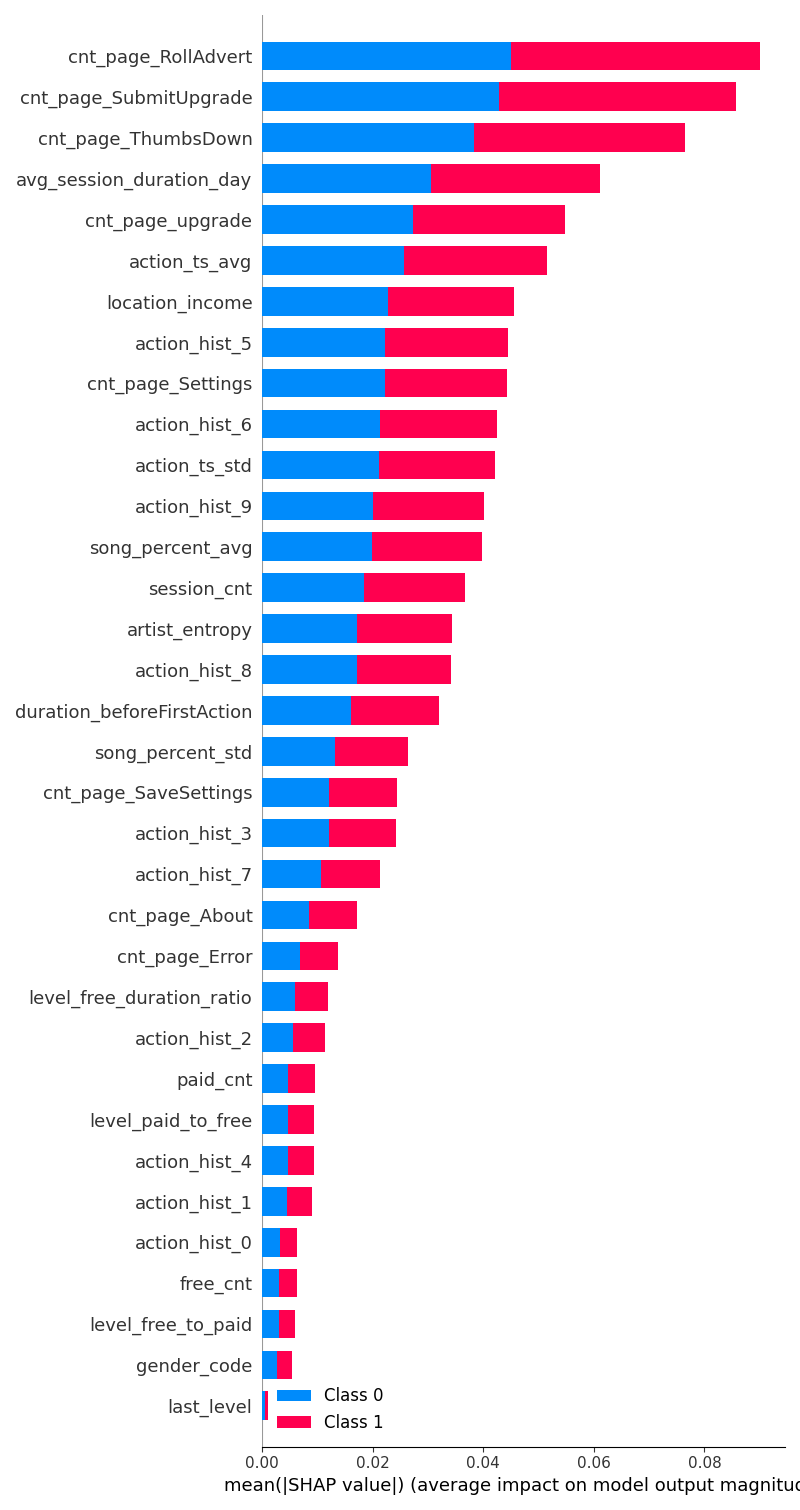

In [14]:
# draw feature importance graph 
plt.close()
shap.summary_plot(shap_values, data_x,max_display=len(features))
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

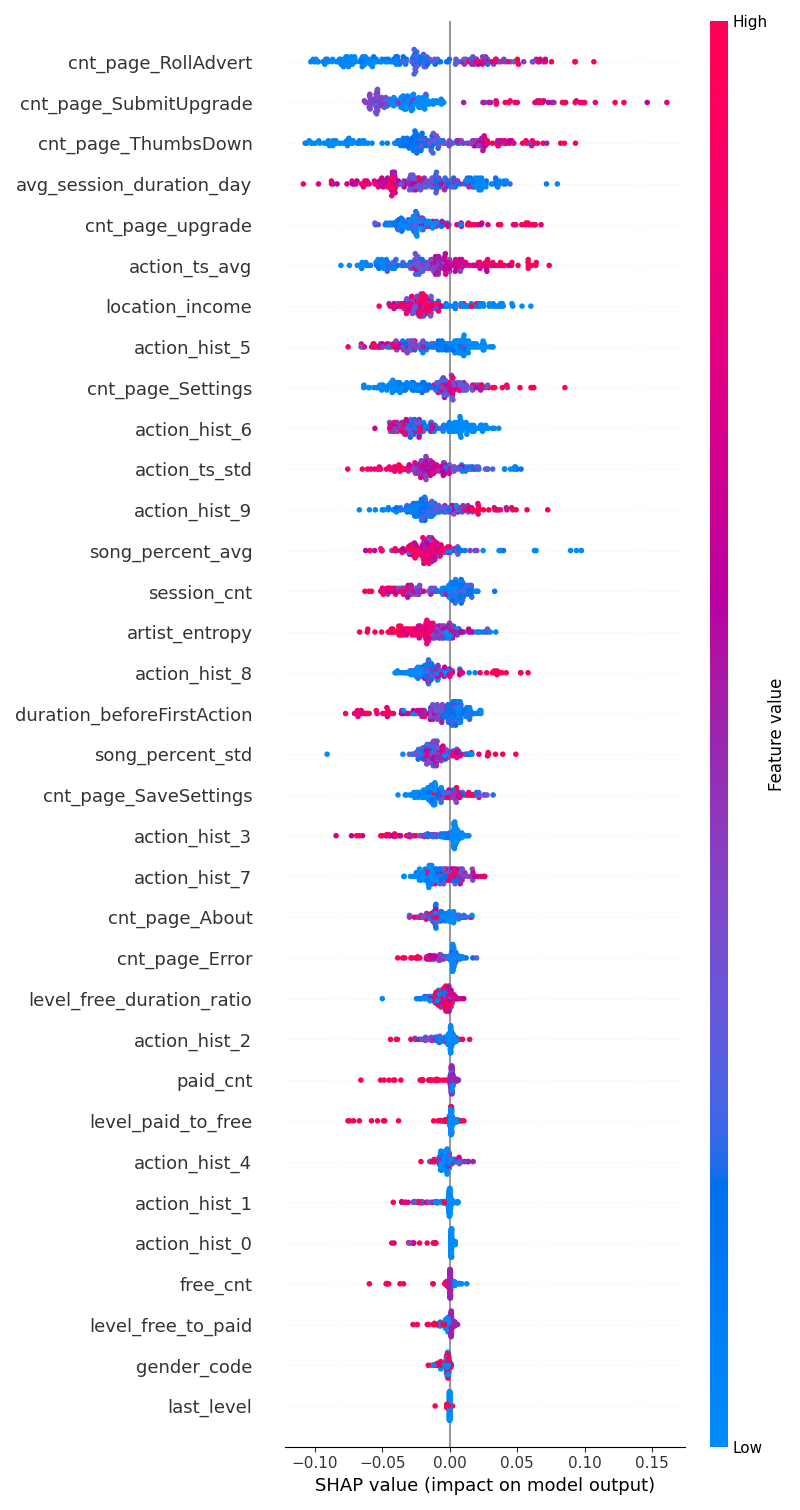

In [15]:
plt.close()
shap.summary_plot(shap_values[1], data_x,max_display=len(features))
%matplot plt




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

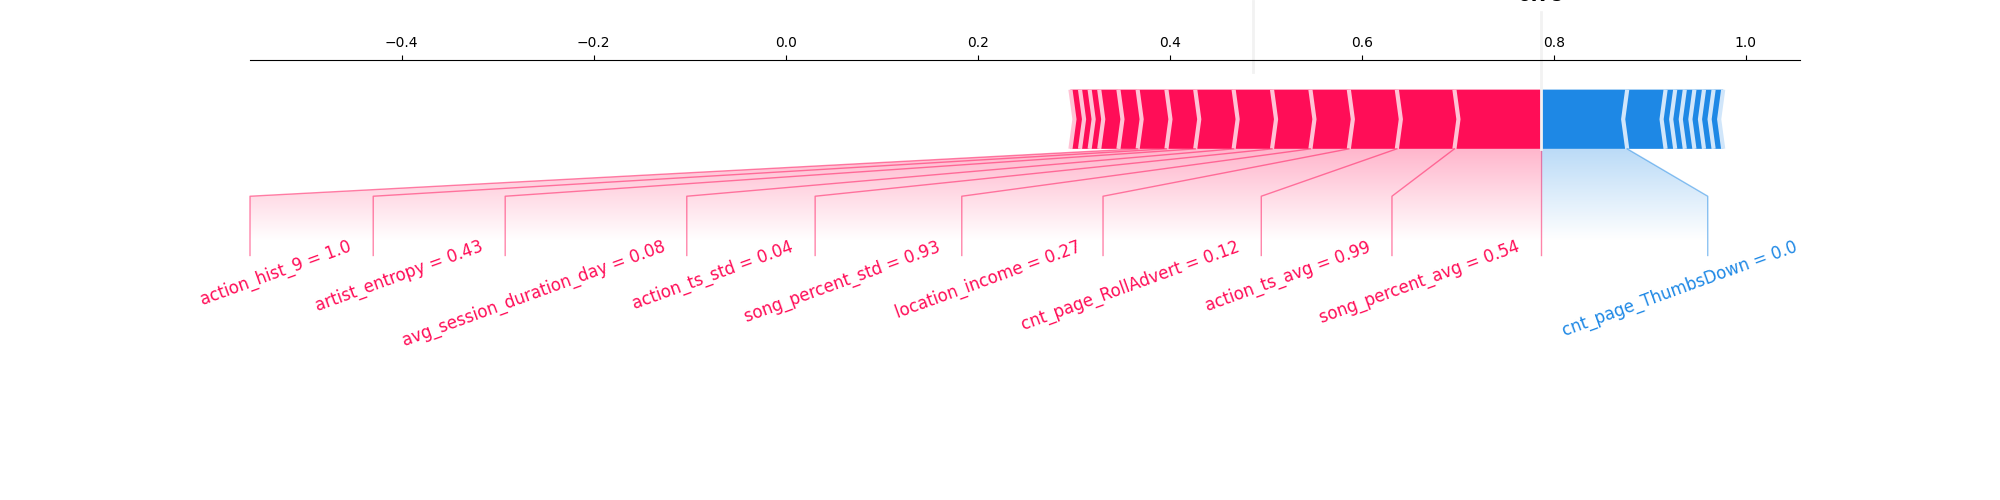

In [47]:

shap.initjs()
plt.close()
shap.plots.force(explainer.expected_value[1], np.round(shap_values[1][3,:],2), np.round(data_x.iloc[3, :],2), matplotlib = True,text_rotation=20,figsize=(20,5))
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

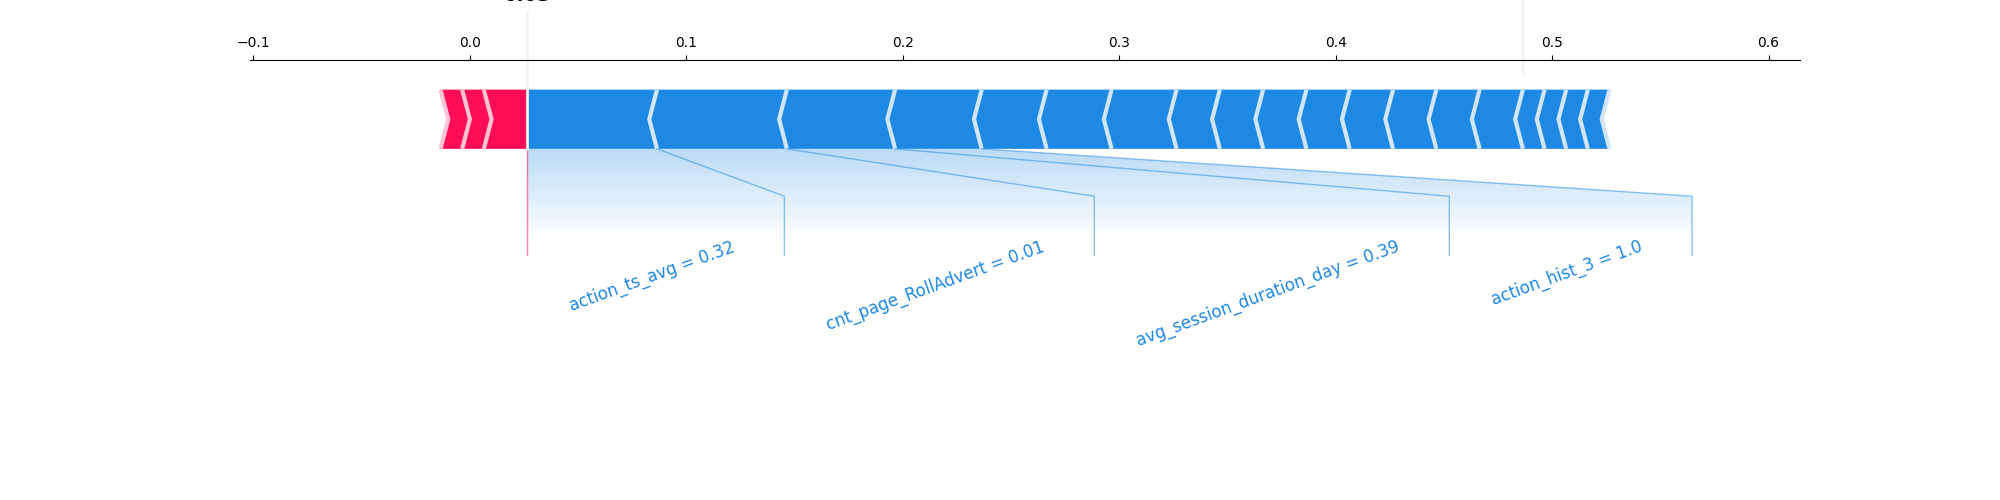

In [48]:

shap.initjs()
plt.close()
shap.plots.force(explainer.expected_value[1], np.round(shap_values[1][0,:],2), np.round(data_x.iloc[0, :],2), matplotlib = True,text_rotation=20,figsize=(20,5))
%matplot plt

In [41]:
np.round(shap_values[1][3,:],2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([-0.01, -0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.01,  0.04,  0.  ,
        0.03,  0.09,  0.04,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.02,
        0.01, -0.01, -0.01,  0.03,  0.06,  0.04, -0.09,  0.05, -0.01,
        0.  , -0.04, -0.01,  0.  , -0.01,  0.02,  0.04])

In [39]:
def shap_force(clf, clf_step_name, index, 
               X_train_df, y_train,
               explainer, shap_vals):
  
    """Takes in a fitted classifier Pipeline, the name of the classifier step,
        the X training DataFrame, the y train array, a shap explainer, and the
        shap values to print the ground truth and predicted label and display
        the shap force plot for the record specified by index.
    Args:
        clf (estimator): An sklearn Pipeline with a fitted classifier as the final step.
        clf_step_name (str): The name given to the classifier step of the pipe.
        X_train_df (DataFrame): A Pandas DataFrame from the train-test-split
            used to train the classifier, with column names corresponding to
            the feature names.
        y_train (series or array): Subset of y data used for training.
        index (int): The index of the observation of interest.
        explainer (shap explainer): A fitted shap.TreeExplainer object.
        shap_vals (array): The array of shap values.
    Returns:
        Figure: Shap force plot showing the breakdown of how the model made
            its prediction for the specified record in the training set.
    """    
    
    
    ## Store model prediction and ground truth label
    pred = clf.named_steps[clf_step_name].predict(X_train_df.iloc[index,:])
    true_label = y_train.iloc[index]
    
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct!'
    else:
        accurate = 'Incorrect'
    
    
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # Print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    print()
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    print('***'*12)
    print()
    
    
    ## Plot the prediction's explanation
    fig = shap.force_plot(explainer.expected_value,
                              shap_vals[index,:],
                              X_train_df.iloc[index,:])
    
    
    return fig

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
shap_force(binary_est, 
           'xgb', # name of fitted classifier step in pipeline
           2, X_train_df, y_train, 
           binary_explainer, 
           binary_shap_values)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

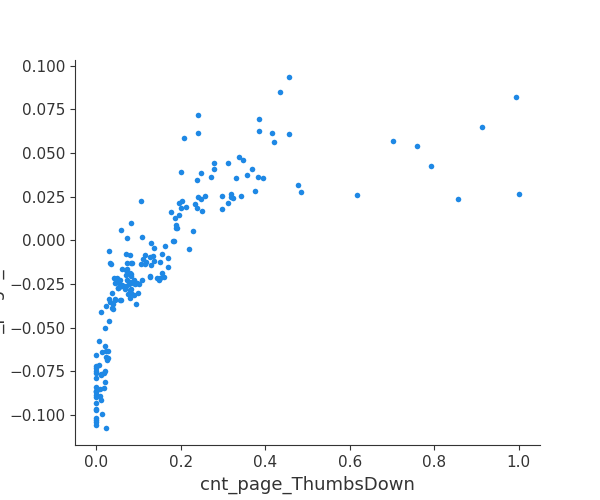

In [17]:
plt.close()
shap.dependence_plot(
     "cnt_page_ThumbsDown",
    shap_values[1],data_x,interaction_index=None  
)
%matplot plt



In [18]:
features

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['gender_code', 'level_free_to_paid', 'level_paid_to_free', 'last_level', 'free_cnt', 'paid_cnt', 'duration_beforeFirstAction', 'location_income', 'level_free_duration_ratio', 'artist_entropy', 'song_percent_avg', 'song_percent_std', 'action_hist_0', 'action_hist_1', 'action_hist_2', 'action_hist_3', 'action_hist_4', 'action_hist_5', 'action_hist_6', 'action_hist_7', 'action_hist_8', 'action_hist_9', 'action_ts_avg', 'action_ts_std', 'cnt_page_ThumbsDown', 'cnt_page_RollAdvert', 'cnt_page_SaveSettings', 'cnt_page_About', 'cnt_page_Settings', 'cnt_page_upgrade', 'cnt_page_Error', 'cnt_page_SubmitUpgrade', 'session_cnt', 'avg_session_duration_day']

In [19]:
shap_interaction_values =  shap.TreeExplainer(model_rf.stages[-1]).shap_interaction_values(data_x)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

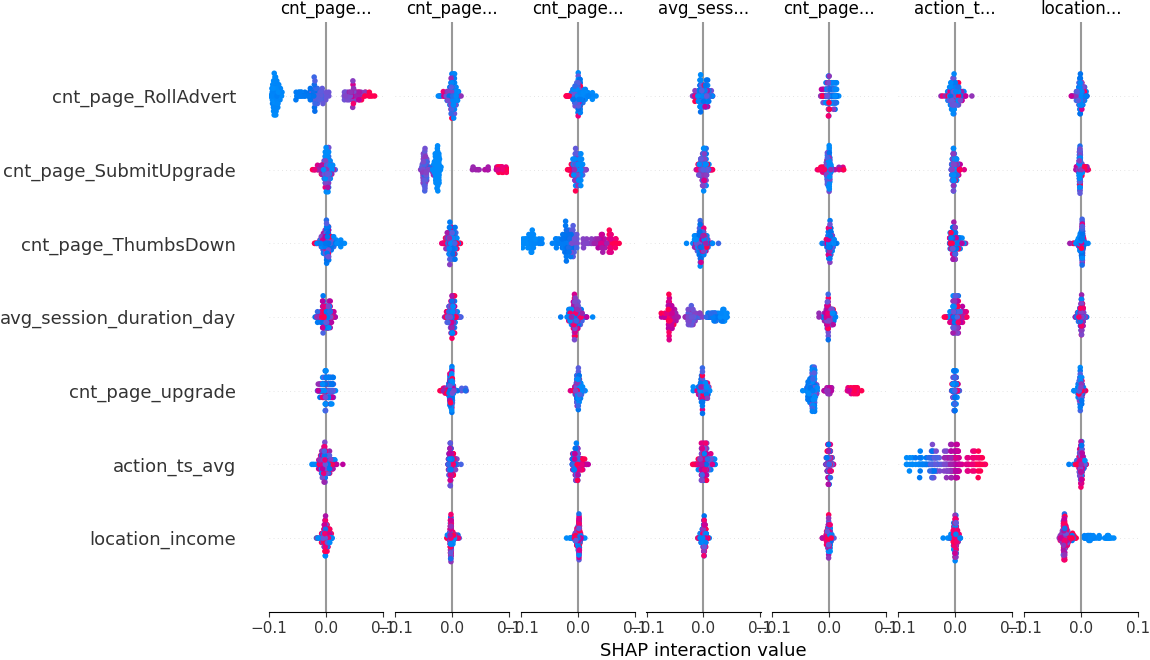

In [20]:
plt.close()
shap.summary_plot(shap_interaction_values[1], data_x)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

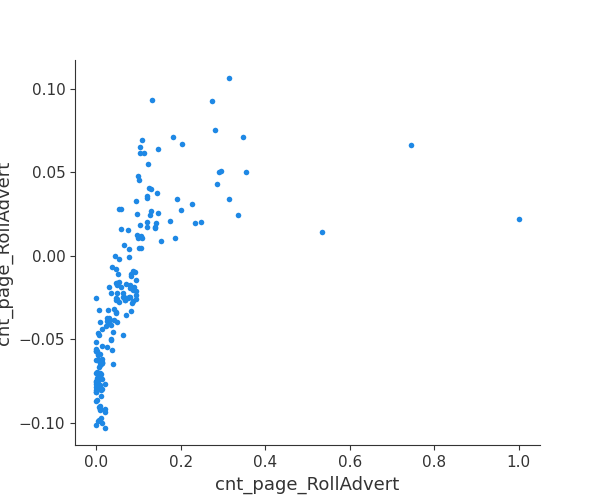

In [21]:
plt.close()
shap.dependence_plot(
     "cnt_page_RollAdvert",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

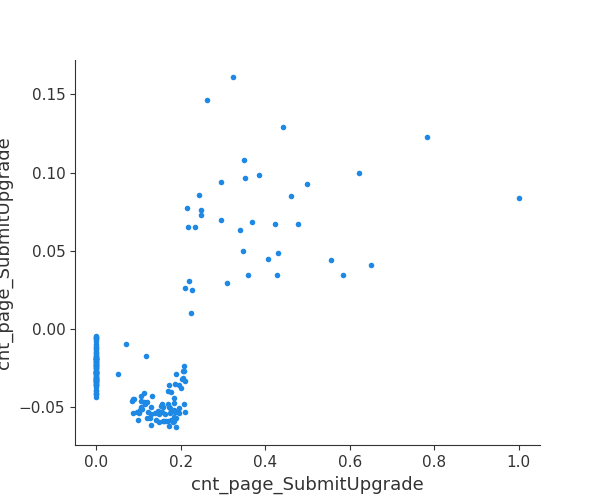

In [22]:
plt.close()
shap.dependence_plot(
     "cnt_page_SubmitUpgrade",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

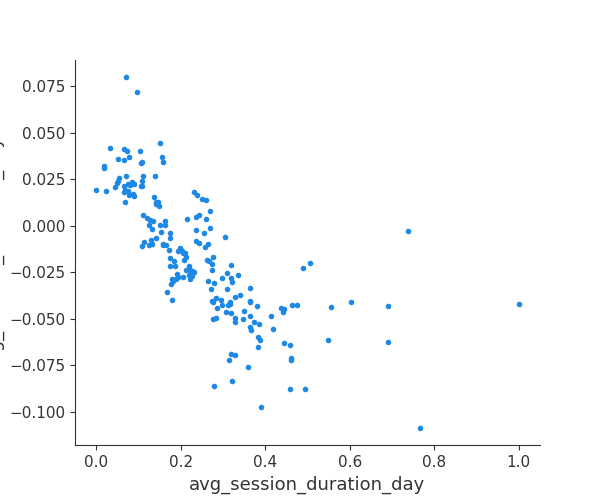

In [35]:
plt.close()
shap.dependence_plot(
     "avg_session_duration_day",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

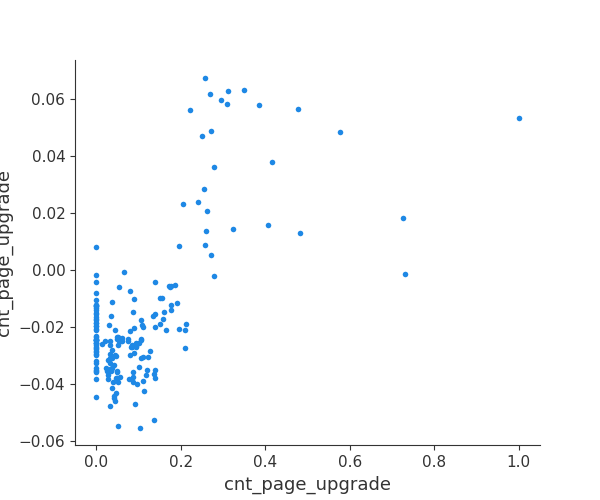

In [36]:
plt.close()
shap.dependence_plot(
     "cnt_page_upgrade",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

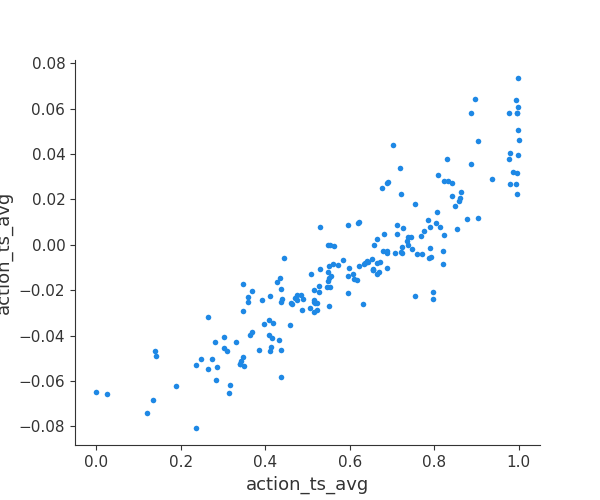

In [25]:
plt.close()
shap.dependence_plot(
     "action_ts_avg",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

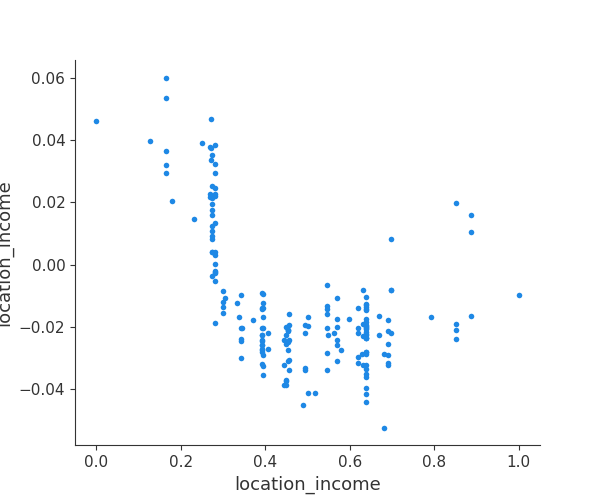

In [26]:
plt.close()
shap.dependence_plot(
     "location_income",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

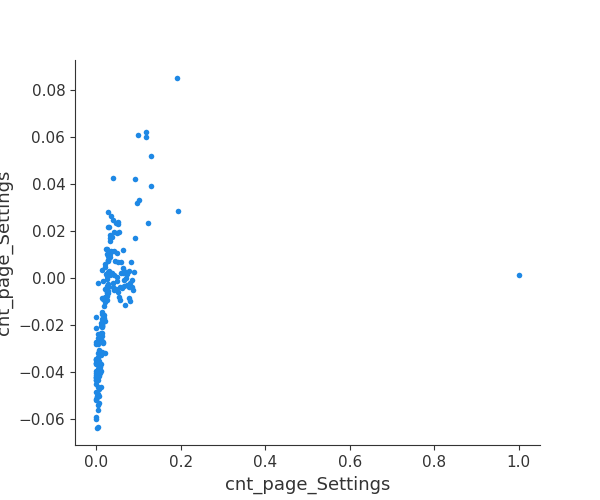

In [27]:
plt.close()
shap.dependence_plot(
     "cnt_page_Settings",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

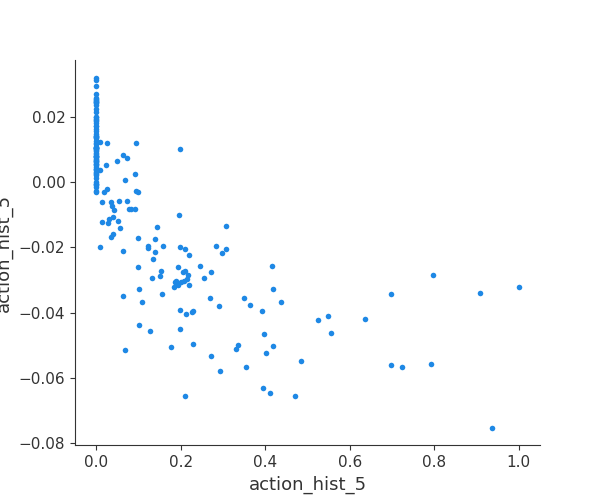

In [28]:
plt.close()
shap.dependence_plot(
     "action_hist_5",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

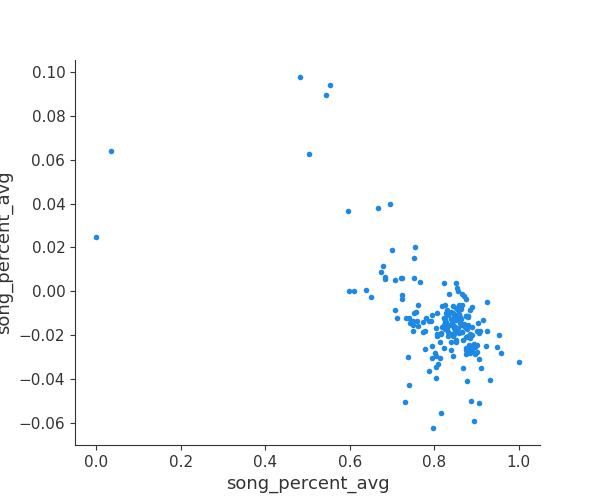

In [29]:
plt.close()
shap.dependence_plot(
     "song_percent_avg",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

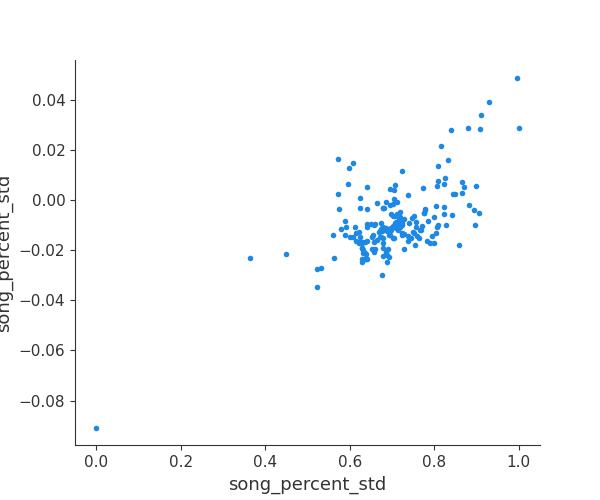

In [30]:
plt.close()
shap.dependence_plot(
     "song_percent_std",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

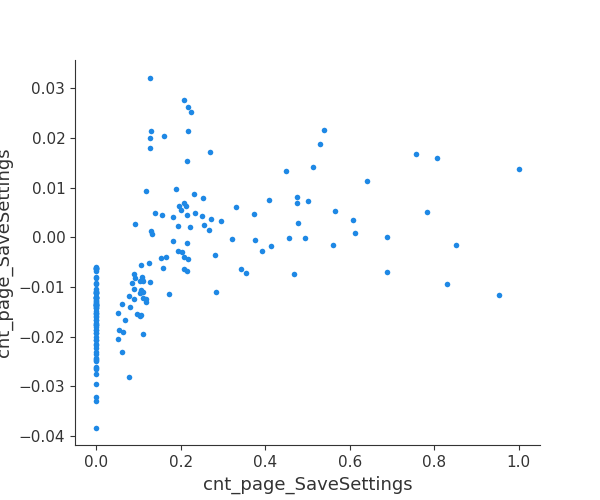

In [31]:
plt.close()
shap.dependence_plot(
     "cnt_page_SaveSettings",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

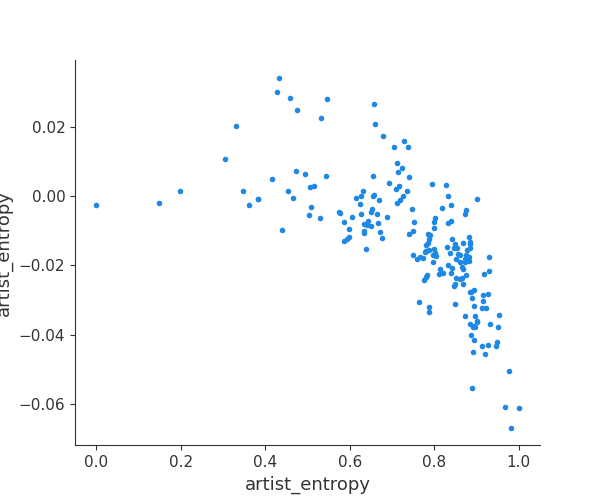

In [32]:
plt.close()
shap.dependence_plot(
     "artist_entropy",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

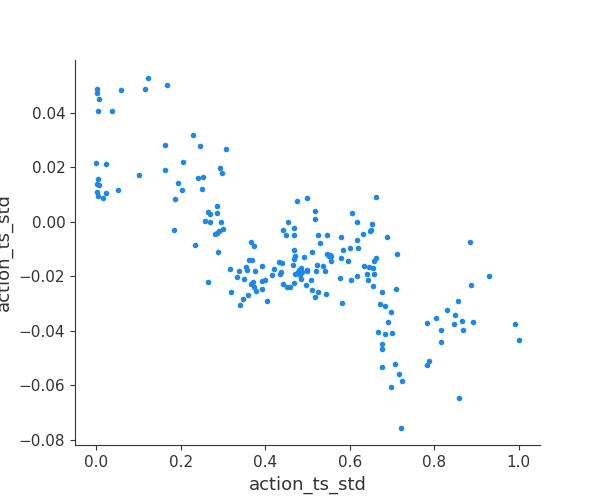

In [33]:
plt.close()
shap.dependence_plot(
     "action_ts_std",
    shap_values[1],data_x,interaction_index=None    
)
%matplot plt


In [34]:
shap.decision_plot(s.expected_value[1], shap_values[1], data_x.columns)
%matplot plt



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 's' is not defined
Traceback (most recent call last):
NameError: name 's' is not defined

